# Light GBM Random Forest - Low Depth; Approach II
As part of the overall stacking model, I will develop two Random Forest (RF) models: one with a relative low depth, and one with a high depth. I define low depth as `max_depth = 5` and high depth as `max_depth = 15`. With the depth defined, I tune the remaining parameters sequentially.  
  
In this notebook, I set out to optimise a **low depth RF model** using the LightGBM package. The optimisation sequence was as follows:  
  
1. No. of Trees (1,000)
2. RFECV (27)
3. Subsampling (0.8)
4. Max Features (12/27)
5. Min Samples in Leaf (5)
6. L1 Regularisation (0.3)
7. L2 Regularisation (0)
  
The final CV score was **83.4568% > 83.3895%**.
  
This sequence differs from Approach I in that subsampling is optimised at an earlier stage. The better approach will be used for subsequent models.  
  
## To-do
Note that both the approaches thus far involves the transformation of all features *before* cross validation is performed. This might inflate the predictive power of the way that the features were processed. The next phase would be to:  
  
1. Implement a custom cross-validation cum grid search function for testing parameters.
2. Add interaction variables to the dataset.

In [1]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
from lightgbm import LGBMClassifier
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Prepare Data

In [2]:
# Import data
df = pd.read_csv('train_clean.csv')

# Data and labels
X = df.drop('Survived', axis = 1)
X = pd.get_dummies(X)
y = df['Survived']

## Global Settings and Functions

In [3]:
# Repeated 5-fold validation
rkf = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=123)

# Function to extract CV test results
def gaia_get_test(cv_object, params, title = 'Test Scores vs. Parameter'):
    
    # Extract test scores
    temp_test = cv_object.cv_results_['mean_test_score']
    
    # Plot
    plt.plot(params, temp_test)
    plt.title(title)
    plt.show()

## Iteration 1: Optimise No. of Trees
With `max_depth = 5`, the optimal number of trees was 1,000. Although accuracy was increasing from 2500 to 3000, this would be computationally too intensive.

In [4]:
# Define parameters
param_n_estimators = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
params = {
    'n_estimators': param_n_estimators
}

In [5]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.75,
        subsample_freq = 1,
        max_depth = 5,
        # n_estimators = ,
        colsample_bytree = 0.5,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X, y)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  5.5min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x0000018400FD6128>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None, colsample_bytree=0.5,
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=3, num_leaves=31, objective='binary', random_state=123,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.75,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Best Score: 0.8246913580246914
Best Params: {'n_estimators': 1000}


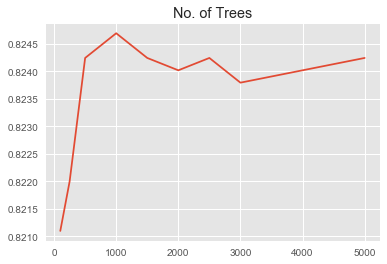

In [6]:
# Save results
best_n_estimators = rf_low.best_params_['n_estimators']

# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

# Plot results
gaia_get_test(rf_low, param_n_estimators, 'No. of Trees')

## Iteration 2: Run RFECV

In [8]:
# Create model
rf_low = RFECV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.75,
        subsample_freq = 1,
        min_split_gain = 0,
        max_depth = 5,
        n_estimators = best_n_estimators,
        colsample_bytree = 0.5,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    cv = RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=123),
    verbose = 1,
    n_jobs = 1
)

# Fit model
rf_low.fit(X, y)

Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 fe

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000001840159FA90>,
   estimator=LGBMClassifier(boosting_type='rf', class_weight=None, colsample_bytree=0.5,
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0, n_estimators=1000,
        n_jobs=3, num_leaves=31, objective='binary', random_state=123,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.75,
        subsample_for_bin=200000, subsample_freq=1),
   n_jobs=1, scoring=None, step=1, verbose=1)

In [9]:
# Results of RFE
print('No. of Features: ' + str(rf_low.n_features_))
print('Feature Ranking:')
rfe_feats = pd.DataFrame(rf_low.ranking_, columns = ['rank'])
rfe_feats['feature'] = X.columns
rfe_feats.sort_values(by = 'rank')

No. of Features: 27
Feature Ranking:


,rank,feature
0,1,pclass_OC
49,1,cabno_OH_C1
46,1,cabletter_OH_B/D/E
42,1,ticlen_OH_LO
41,1,ticlen_OH_L6
40,1,ticlen_OH_L5
32,1,age_OH_A3
31,1,age_OH_A2
25,1,title_OH_Mr.
22,1,pclass_OH_CLASS3


In [10]:
# Save results to csv
rfe_feats.to_csv('lgbm_rfe.csv', index = False)

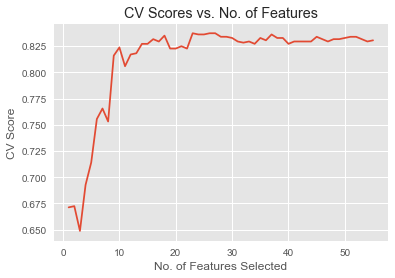

In [11]:
# Plots
plt.figure()
plt.title('CV Scores vs. No. of Features')
plt.xlabel("No. of Features Selected")
plt.ylabel("CV Score")
plt.plot(range(1, len(rf_low.grid_scores_) + 1), rf_low.grid_scores_)
plt.show()

## Subset Features

In [12]:
# Subset features
X_sub = X.iloc[:, (rf_low.ranking_ == 1)]

## Iteration 3: Optimise Subsampling

Fitting 25 folds for each of 8 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:  1.8min finished


Best Score: 0.8285072951739618
Best Params: {'subsample': 0.8}


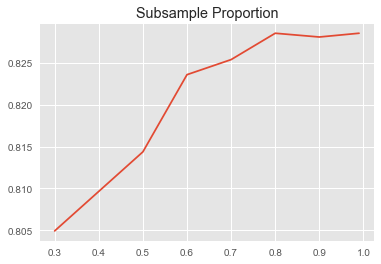

In [13]:
# Define parameters
param_subsample = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
params = {
    'subsample': param_subsample
}

# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        # subsample = 0.9,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = best_n_estimators,
        colsample_bytree = 0.5,
        # min_child_samples = 1,
        # reg_alpha = 0.1,
        # reg_lambda = 0,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

# Save results
best_subsample = rf_low.best_params_['subsample']

# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

# Plot results
gaia_get_test(rf_low, param_subsample, 'Subsample Proportion')

## Iteration 4: Optimise Max Features

In [14]:
# Define parameters
param_max_feat = np.arange(2/X_sub.shape[1], 1, 1/X_sub.shape[1])
params = {
    'colsample_bytree': param_max_feat
}

In [15]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = best_subsample,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = best_n_estimators,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 25 candidates, totalling 625 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done 625 out of 625 | elapsed:  5.8min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x0000018400FD6128>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=3, num_leaves=31, objective='binary', random_state=123,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'colsample_bytree': array([0.07407, 0.11111, 0.14815, 0.18519, 0.22222, 0.25926, 0.2963 ,
       0.33333, 0.37037, 0.40741, 0.44444, 0.48148, 0.51852, 0.55556,
       0.59259, 0.62963, 0.66667, 0.7037 , 0.74074, 0.77778, 0.81481,
       0.85185, 0.88889, 0.92593, 0.96296])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Best Score: 0.8303030303030303
Best Params: {'colsample_bytree': 0.4444444444444444}


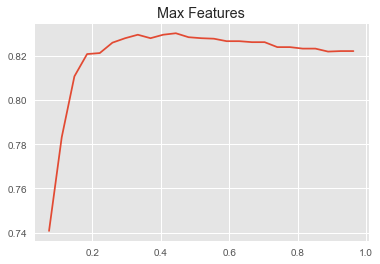

In [16]:
# Save results
best_colsample_bytree = rf_low.best_params_['colsample_bytree']

# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

# Plot results
gaia_get_test(rf_low, param_max_feat, 'Max Features')

## Iteration 4: Optimise Minimum Samples in Terminal Nodes

In [17]:
# Define parameters
param_min_leaf = [1,5,10,20,30,40,50]
params = {
    'min_child_samples': param_min_leaf
}

In [18]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = best_subsample,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 7 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   50.4s
[Parallel(n_jobs=3)]: Done 175 out of 175 | elapsed:  2.1min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x0000018400FD6128>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None,
        colsample_bytree=0.4444444444444444, learning_rate=0.1,
        max_depth=5, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=1000, n_jobs=3, num_leaves=31,
        objective='binary', random_state=123, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'min_child_samples': [1, 5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Best Score: 0.8336700336700337
Best Params: {'min_child_samples': 5}


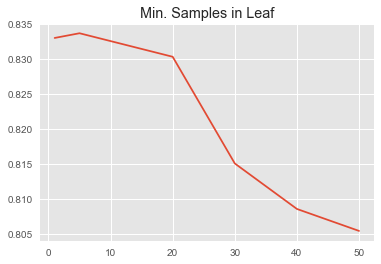

In [19]:
# Save results
best_min_child_samples = rf_low.best_params_['min_child_samples']

# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

# Plot results
gaia_get_test(rf_low, param_min_leaf, 'Min. Samples in Leaf')

## Iteration 5: Optimise L1 Regularisation

In [20]:
# Define parameters
param_alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_alpha': param_alpha
}

In [21]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = best_subsample,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        min_child_samples = best_min_child_samples,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   46.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.0min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x0000018400FD6128>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None,
        colsample_bytree=0.4444444444444444, learning_rate=0.1,
        max_depth=5, min_child_samples=5, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=1000, n_jobs=3, num_leaves=31,
        objective='binary', random_state=123, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Best Score: 0.8345679012345679
Best Params: {'reg_alpha': 0.3}


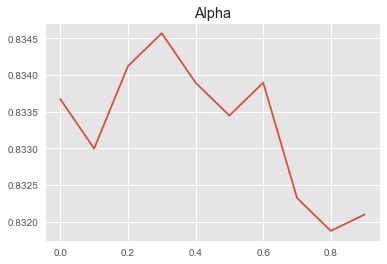

In [22]:
# Save results
best_reg_alpha = rf_low.best_params_['reg_alpha']

# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

# Plot results
gaia_get_test(rf_low, param_alpha, 'Alpha')

## Iteration 6: Optimise L2 Regularisation

In [23]:
# Define parameters
param_lambda = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_lambda': param_lambda
}

In [24]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = best_subsample,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        min_child_samples = best_min_child_samples,
        reg_alpha = best_reg_alpha,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   31.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  2.5min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x0000018400FD6128>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None,
        colsample_bytree=0.4444444444444444, learning_rate=0.1,
        max_depth=5, min_child_samples=5, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=1000, n_jobs=3, num_leaves=31,
        objective='binary', random_state=123, reg_alpha=0.3,
        reg_lambda=0.0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Best Score: 0.8345679012345679
Best Params: {'reg_lambda': 0}


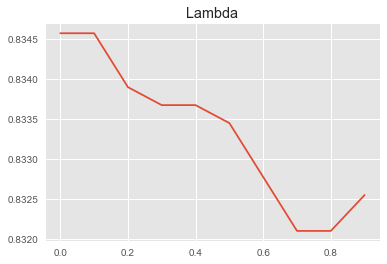

In [25]:
# Save results
best_reg_lambda = rf_low.best_params_['reg_lambda']

# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

# Plot results
gaia_get_test(rf_low, param_lambda, 'Lambda')

## Best Parameters

In [26]:
# Print best parameters
print('No. of Trees'.rjust(21) + ' : ' + str(best_n_estimators))
print('Subsample'.rjust(21) + ' : ' + str(best_subsample))
print('Max Features'.rjust(21) + ' : ' + str(best_colsample_bytree))
print('Min. Samples in Leaf'.rjust(21) + ' : ' + str(best_min_child_samples))
print('Alpha'.rjust(21) + ' : ' + str(best_reg_alpha))
print('Lambda'.rjust(21) + ' : ' + str(best_reg_lambda))

         No. of Trees : 1000
            Subsample : 0.8
         Max Features : 0.4444444444444444
 Min. Samples in Leaf : 5
                Alpha : 0.3
               Lambda : 0
